In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/iris/Iris.csv
/kaggle/input/iris/database.sqlite


# ML project for ACM-VIT Recruitments Round 2
Prepare a logistic regression model and an Artificial Neural Network to classify features from the Iris dataset. Explain in detail the various data-preprocessing techniques used, performance metrics for both the models and plot graphs for the same.

### Importing the dependencies

In [2]:
import numpy as np
import pandas as pd

import seaborn as sns #used for creating correlation heatmap
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

import tensorflow as tf #used for creating the neural network
from tensorflow.keras import Input
from tensorflow.keras.layers import Dense
from tensorflow.keras import Model

First, we load the dataset into a pandas dataframe called df

In [3]:
df = pd.read_csv('/kaggle/input/iris/Iris.csv')
df.head() #this will show the first 5 rows of the dataframe

,Id,SepalLengthCm,SepalWidthCm,PetalLengthCm,PetalWidthCm,Species
0,1,5.1,3.5,1.4,0.2,Iris-setosa
1,2,4.9,3.0,1.4,0.2,Iris-setosa
2,3,4.7,3.2,1.3,0.2,Iris-setosa
3,4,4.6,3.1,1.5,0.2,Iris-setosa
4,5,5.0,3.6,1.4,0.2,Iris-setosa


In [4]:
df.describe() #this will show some basic statistics about our data

,Id,SepalLengthCm,SepalWidthCm,PetalLengthCm,PetalWidthCm
count,150.000000,150.000000,150.000000,150.000000,150.000000
mean,75.500000,5.843333,3.054000,3.758667,1.198667
std,43.445368,0.828066,0.433594,1.764420,0.763161
min,1.000000,4.300000,2.000000,1.000000,0.100000
25%,38.250000,5.100000,2.800000,1.600000,0.300000
50%,75.500000,5.800000,3.000000,4.350000,1.300000
75%,112.750000,6.400000,3.300000,5.100000,1.800000
max,150.000000,7.900000,4.400000,6.900000,2.500000


Checking if there are any null values in the dataframe:

In [5]:
df.isnull().sum()

Id               0
SepalLengthCm    0
SepalWidthCm     0
PetalLengthCm    0
PetalWidthCm     0
Species          0
dtype: int64

Hence we can see that there no null values. Had there been any null values, we would have to deal with them with suitable methods such as replacing the null values with the modes of their respective columns.


# Data Visualization (Exploratory Data Analysis)

Now, we will plot a scatter plot between the sepal length and sepal width, and give a color to each of the flower species to make it easier to see how the relationship between sepal length and width affects the species

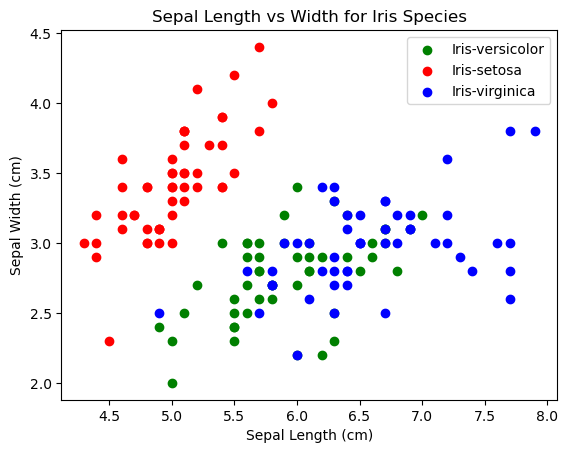

In [6]:
# Create a dictionary to map each species to a different color
colors = {'Iris-setosa': 'red', 'Iris-versicolor': 'green', 'Iris-virginica': 'blue'}

# Create a scatter plot of SepalLengthCm vs SepalWidthCm, using different colors for each species. Here fig is the whole figure and ax is a subplot
fig, ax = plt.subplots()
for species in set(df['Species']):
    subset = df[df['Species'] == species]
    ax.scatter(subset['SepalLengthCm'], subset['SepalWidthCm'], c=colors[species], label=species)
    
ax.set_xlabel('Sepal Length (cm)')
ax.set_ylabel('Sepal Width (cm)')
ax.set_title('Sepal Length vs Width for Iris Species')
ax.legend()

# Show the plot
plt.show()


From this graph, we can see clearly that setosa is linearly separable from the other two species based on sepal length vs width alone. The other two species are not linearly separable

Now we plot a scatter plot between Petal Length vs Petal Width to see if this relationship gives a better sepation

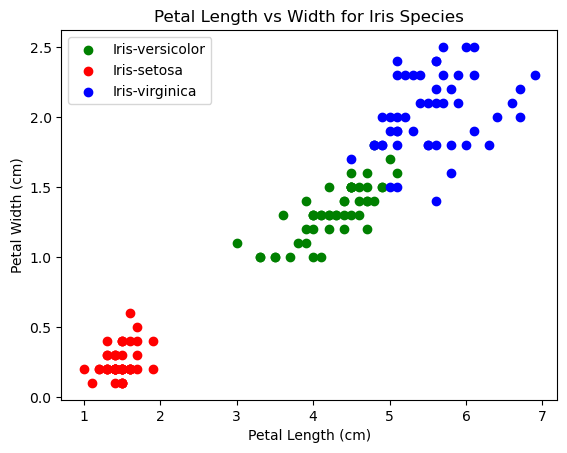

In [7]:
fig, ax = plt.subplots()
for species in set(df['Species']):
    subset = df[df['Species'] == species]
    ax.scatter(subset['PetalLengthCm'], subset['PetalWidthCm'], c=colors[species], label=species)

ax.set_xlabel('Petal Length (cm)')
ax.set_ylabel('Petal Width (cm)')
ax.set_title('Petal Length vs Width for Iris Species')
ax.legend()

plt.show()

So petal length vs width gives a better separation.

## Histograms
Now we plot the **Histograms** to see how the data is distributed for different columns

Also since the Id column is unnecessary for our purpose, we will remove it.

In [8]:
df.drop('Id',axis=1,inplace=True) 
#axis=1 means that it should be column wise, inplace means that this change will be overwritten in df

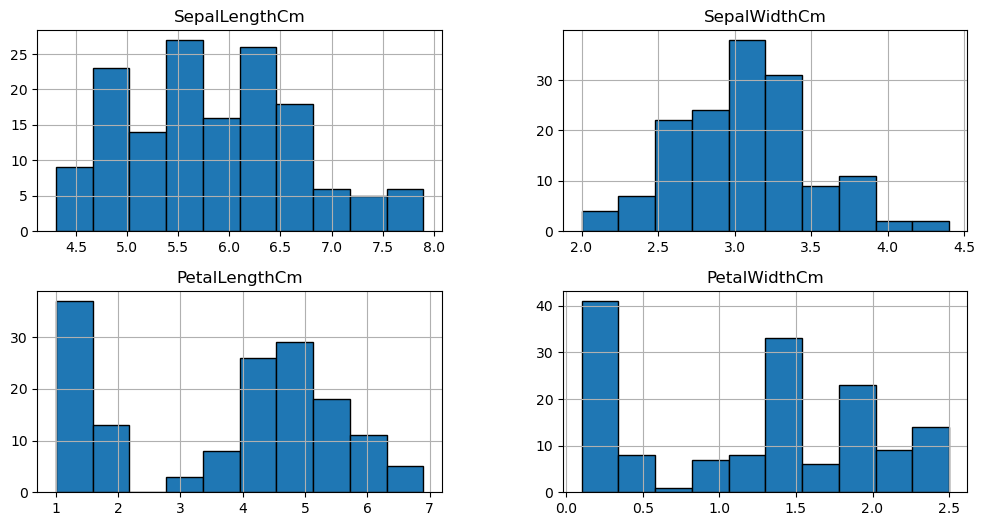

In [9]:
df.hist(edgecolor='black')
fig=plt.gcf() #get current figure
fig.set_size_inches(12,6)
plt.show()

We can see that sepal length and width are distributed fairly normally, whereas petal length and width have a sort of bimodal distribution.

## Correlation Heatmap

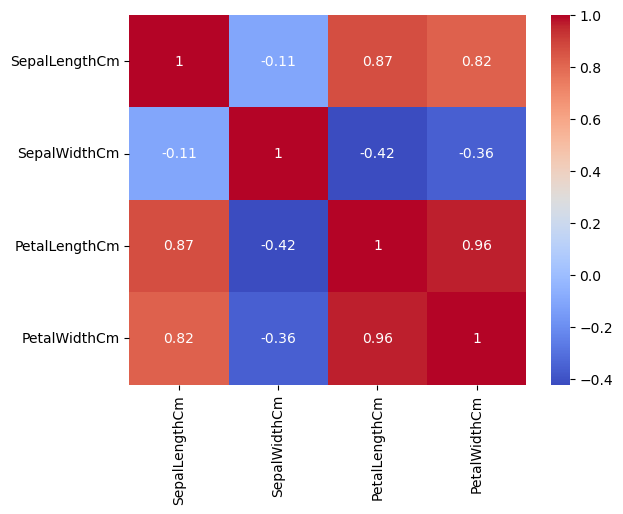

In [10]:
plt.figure() 
sns.heatmap(df.corr(),annot=True,cmap='coolwarm') #this will draw heatmap with input as the correlation matrix calculted by(df.corr())
plt.show()

From this heatmap we can see that petal width and petal length are highly correlated with each other. Based on this, we could choose to drop one of these features, but for this dataset it is fine to not drop it because we only have 4 features.

## Identifying Outliers using Boxplot Graph

After this, we can create a boxplot to see if there are any outliers in the data. If there are, then we will deal with them later on.

<AxesSubplot:>

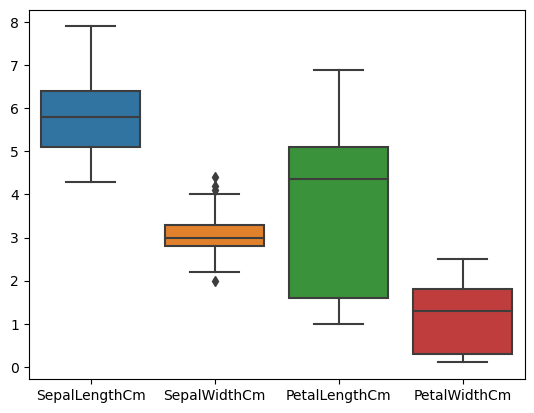

In [11]:
sns.boxplot(data=df)

From the above plot we can see that in SepalWidthCm, values above 4 and below 2 are outliers.

# Data Preprocessing

### Identifying and removing outliers
First we will identify and remove outliers from our dataset. For identifying and removing outliers from SepalWidthCm, we will use Z-score method

In [12]:
m = np.mean(df.SepalWidthCm)
m

3.0540000000000003

In [13]:
out = []
sd = np.std(df.SepalWidthCm)
for i in df.SepalWidthCm: 
    z = (i-m)/sd
    if np.abs(z) > 3: 
        out.append(i)
print("Outliers:",out)

Outliers: [4.4]


Since there is only 1 outlier, and it is not highly different from the rest of the values, it is better to not drop it as the size of our dataset is small.

## Standardization:

Standardization is the Z-score normalization. We perform it so that the data is rescaled to have a mean of 0 and standard deviation of 1. This makes our model learn better. We can either use StandardScaler from the sklearn.preprocessing library, or implement it using this formula:

Z = (X-mean)/sd

In [14]:
data = df[['SepalLengthCm', 'SepalWidthCm', 'PetalLengthCm', 'PetalWidthCm']].values
mean = np.mean(data, axis=0)
std = np.std(data, axis=0)
standardized_data = (data - mean) / std
df[['SepalLengthCm', 'SepalWidthCm', 'PetalLengthCm', 'PetalWidthCm']] = standardized_data
df

,SepalLengthCm,SepalWidthCm,PetalLengthCm,PetalWidthCm,Species
0,-0.900681,1.032057,-1.341272,-1.312977,Iris-setosa
1,-1.143017,-0.124958,-1.341272,-1.312977,Iris-setosa
2,-1.385353,0.337848,-1.398138,-1.312977,Iris-setosa
3,-1.506521,0.106445,-1.284407,-1.312977,Iris-setosa
4,-1.021849,1.263460,-1.341272,-1.312977,Iris-setosa
...,...,...,...,...,...
145,1.038005,-0.124958,0.819624,1.447956,Iris-virginica
146,0.553333,-1.281972,0.705893,0.922064,Iris-virginica
147,0.795669,-0.124958,0.819624,1.053537,Iris-virginica
148,0.432165,0.800654,0.933356,1.447956,Iris-virginica


## Normalization:
Normalization rescales the values into a range of [0,1]. It can be useful when the range of values in different features of the dataset is significantly different. Here this is not the case, all the values are in similar ranges especially after applying standardization. Hence we will not perform this step.


## Separating training data and output labels:

Now, we separate the training data and the output labels. This makes it easier to apply preprocessing methods on the training data.

Y will store the output labels, i.e the species

X will store rest of the data which is used for training the model

In [15]:
Y = df['Species']
X = df.drop('Species', axis=1)
Y

0         Iris-setosa
1         Iris-setosa
2         Iris-setosa
3         Iris-setosa
4         Iris-setosa
            ...      
145    Iris-virginica
146    Iris-virginica
147    Iris-virginica
148    Iris-virginica
149    Iris-virginica
Name: Species, Length: 150, dtype: object

In [16]:
X

,SepalLengthCm,SepalWidthCm,PetalLengthCm,PetalWidthCm
0,-0.900681,1.032057,-1.341272,-1.312977
1,-1.143017,-0.124958,-1.341272,-1.312977
2,-1.385353,0.337848,-1.398138,-1.312977
3,-1.506521,0.106445,-1.284407,-1.312977
4,-1.021849,1.263460,-1.341272,-1.312977
...,...,...,...,...
145,1.038005,-0.124958,0.819624,1.447956
146,0.553333,-1.281972,0.705893,0.922064
147,0.795669,-0.124958,0.819624,1.053537
148,0.432165,0.800654,0.933356,1.447956


## Output Label Encoding:

We must change the labels of the output from text values to numerical values. For doing this, we will use label encoding and assign one of 0,1,2 for each species.

In [17]:
le = LabelEncoder()
Y = le.fit_transform(df['Species'])
Y

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2])

## Train-Test Split

Now we will split the dataset into training set and test set. 70% of the values will be used for training and 30% for testing the model. We set the value of random_state as 45 to get a consistent and reproducable result.

In [18]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size = 0.7, random_state=45)

# Training the Logistic Regression Model:

In [19]:
from sklearn.linear_model import LogisticRegression
lr_model = LogisticRegression(max_iter=1000)
lr_model.fit(X_train, Y_train)

LogisticRegression(max_iter=1000)

## Logistic Regression Performance Metrics (Accuracy):

In [20]:
LR_acc = lr_model.score(X_test,Y_test)
print("Accuracy of Logistic Regression Model: ", LR_acc * 100)

Accuracy of Logistic Regression Model:  95.55555555555556


# Creating the Neural Network Model

We will use Tensorflow to create the neural network. The activation function used is RELU for the input layer and hidden layers and softmax for the output layer. Softmax is used for multiclass classification.

In [21]:
inputs = Input(shape=(4,)) #since there are 4 features
x1 = Dense(64, activation='relu')(inputs) #first hidden layer with 64 nodes
x2 = Dense(16, activation='relu')(x1) # second hidden layer
outputs = Dense(3, activation='softmax')(x2) #as there are 3 output classes

nn_model = Model(inputs=inputs, outputs=outputs)

We can plot a simple diagram of the model to understand its structure as follows. As we can see it has 4 layers: input layer, 2 hidden layers and 1 output layer.

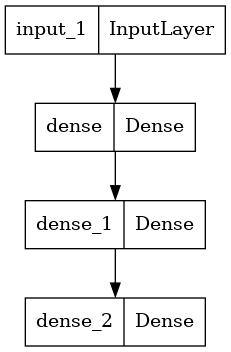

In [22]:
tf.keras.utils.plot_model(nn_model)

In [23]:
nn_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

Here 'adam' is used as the optimizer function, which is an efficient algorithm for gradient descent, which is used to calculate the values of the parameters after every epoch.

'sparse_categorical_crossentropy' is used as the loss function. In this, the model predictions are compared to the true class labels as integers, and the loss is calculated as the cross-entropy between the predicted probabilities and the true class labels. It is generally used in multiclass categorical classification problems.

## Training the Neural Network

Now we will train the neural network and note the loss values at different epochs in 'log'

In [24]:
epochs = 500 #define number of iterations for training

In [25]:
log = nn_model.fit(X_train, Y_train, validation_split=0.3, batch_size = 32, epochs=epochs)

Epoch 1/500
3/3 [==============================] - 1s 119ms/step - loss: 1.1119 - accuracy: 0.3836 - val_loss: 1.0479 - val_accuracy: 0.5000
Epoch 2/500
3/3 [==============================] - 0s 16ms/step - loss: 1.0591 - accuracy: 0.4932 - val_loss: 1.0005 - val_accuracy: 0.5625
Epoch 3/500
3/3 [==============================] - 0s 16ms/step - loss: 1.0099 - accuracy: 0.5616 - val_loss: 0.9570 - val_accuracy: 0.5938
Epoch 4/500
3/3 [==============================] - 0s 16ms/step - loss: 0.9659 - accuracy: 0.5890 - val_loss: 0.9150 - val_accuracy: 0.6562
Epoch 5/500
3/3 [==============================] - 0s 16ms/step - loss: 0.9262 - accuracy: 0.6164 - val_loss: 0.8742 - val_accuracy: 0.7188
Epoch 6/500
3/3 [==============================] - 0s 16ms/step - loss: 0.8880 - accuracy: 0.7397 - val_loss: 0.8365 - val_accuracy: 0.7812
Epoch 7/500
3/3 [==============================] - 0s 16ms/step - loss: 0.8511 - accuracy: 0.7808 - val_loss: 0.8022 - val_accuracy: 0.7812
Epoch 8/500
3/3 [==

### Plotting the learning curve:

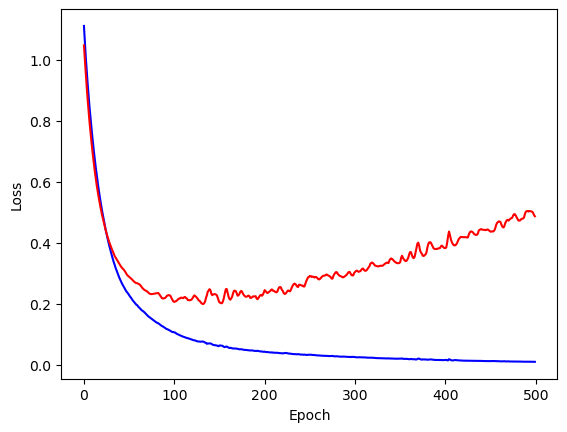

In [26]:
plt.figure()
plt.plot(range(epochs), log.history['loss'], color='blue')
plt.plot(range(epochs), log.history['val_loss'], color='red')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

From the above graph we can see that the validation (test) loss is continuously going up. Clearly our model is **overfitting**. This is because the neural network created with 2 hidden layers and 64 and 16 nodes for the hidden layers is far too complex and powerful for this simple dataset.

So, we will create another neural network which will be much simpler than the previous one.

In [42]:
inputs = Input(shape=(4,)) #since there are 4 features
x = Dense(16, activation='relu')(inputs) #hidden layer with 16 nodes
outputs = Dense(3, activation='softmax')(x) #as there are 3 output classes

nn2_model = Model(inputs=inputs, outputs=outputs)

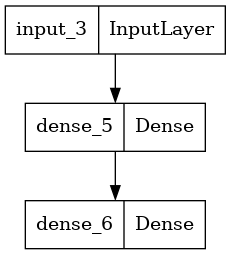

In [43]:
tf.keras.utils.plot_model(nn2_model)

In [44]:
nn2_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [45]:
log = nn2_model.fit(X_train, Y_train, validation_split=0.3, batch_size = 32, epochs=epochs)

Epoch 1/500
3/3 [==============================] - 1s 92ms/step - loss: 1.1747 - accuracy: 0.1781 - val_loss: 1.1358 - val_accuracy: 0.2188
Epoch 2/500
3/3 [==============================] - 0s 20ms/step - loss: 1.1535 - accuracy: 0.1918 - val_loss: 1.1146 - val_accuracy: 0.2500
Epoch 3/500
3/3 [==============================] - 0s 16ms/step - loss: 1.1350 - accuracy: 0.1918 - val_loss: 1.0937 - val_accuracy: 0.3750
Epoch 4/500
3/3 [==============================] - 0s 16ms/step - loss: 1.1148 - accuracy: 0.2192 - val_loss: 1.0731 - val_accuracy: 0.4062
Epoch 5/500
3/3 [==============================] - 0s 15ms/step - loss: 1.0961 - accuracy: 0.2329 - val_loss: 1.0526 - val_accuracy: 0.4688
Epoch 6/500
3/3 [==============================] - 0s 15ms/step - loss: 1.0774 - accuracy: 0.2603 - val_loss: 1.0326 - val_accuracy: 0.5312
Epoch 7/500
3/3 [==============================] - 0s 15ms/step - loss: 1.0585 - accuracy: 0.3014 - val_loss: 1.0130 - val_accuracy: 0.5312
Epoch 8/500
3/3 [===

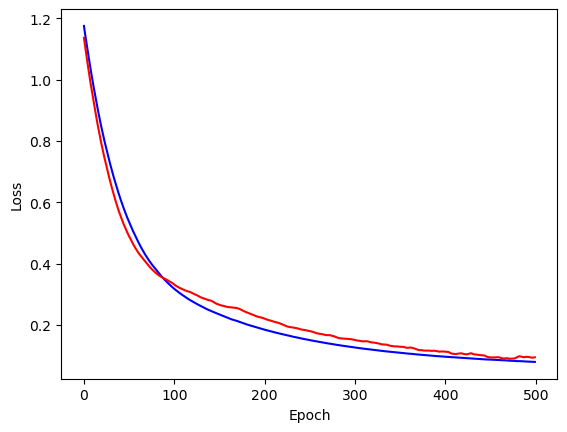

In [46]:
plt.figure()
plt.plot(range(epochs), log.history['loss'], color='blue')
plt.plot(range(epochs), log.history['val_loss'], color='red')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

As we can see, this model fits a lot better than the previous one.

In [47]:
nn_acc = nn2_model.evaluate(X_test, Y_test)

2/2 [==============================] - 0s 7ms/step - loss: 0.1166 - accuracy: 0.9556


In [48]:

print("Accuracy of Logistic Regression Model: ", LR_acc * 100)
print("Accuracy of Neural Network Model: ", nn_acc[-1] * 100)

Accuracy of Logistic Regression Model:  95.55555555555556
Accuracy of Neural Network Model:  95.55555582046509


# Final Thoughts

Finally we have arrived at the accuracies of both of the models, which are almost exactly the same, at 95.5% 

This shows that both the models have a similar performance. So we cannot say if one model is better than the other. Even if there was a major difference in accuracies, we have to consider that neural networks are more flexible, require more computation power, and generally work better on larger datasets.